# Contexto

Você é o responsável por dados e análises no time de Relacionamento com o Cliente. Este time é responsável por cuidar dos nossos clientes, tirando todas as dúvidas e os ajudando a fazer melhor uso dos nossos produtos.

Nos últimos tempos tivemos alguns problemas e precisamos da sua ajuda para tomarmos as melhores decisões para melhor atender nossos clientes. 


### Questões

1.	Foi implementada no dia 1 de agosto uma funcionalidade nova no site do Ton que acredita que irá diminuir a quantidade de chamados recebidos. Avalie se a implementação teve um impacto estatisticamente relevante.

2.	Foi notado pelo nosso time que clientes recem credenciados possuem um comportamento específico em relação à quantidade de chamados realizados logo após seu credenciamento. Identifique e prepare alguma forma de visualizar essa diferença notada pelos agentes.

3.	Para conseguir melhorar a qualidade do nosso atendimento ao cliente, foi proposto que a alguns chamados tenham prioridade de atendimento. Levando em consideração o motivo dos chamados, como você estabeleceria essa prioridade da fila de espera? Sugestão: Proponha uma clusterização da base de clientes que julgue atender da melhor forma a necessidade apresentada.

4.	Escreva duas queries em SQL que retornem: 

i) o volume de chamados por semana dos últimos três meses para cada cluster de clientes proposto na questão 3.

ii) uma série histórica dia a dia, que para cada dia retorne o número de chamados referentes aos últimos 30 dias (por exemplo, para o dia 30/01, a query deve retornar a quantidade de chamados totais entre os dias 01/01 e 30/01)


5.	Questão de estudo livre: Como é esperado de um analista de dados, traga insights relevantes sobre pontos de atenção e possíveis melhorias que você identificou ao analisar ambas as bases de dados. Além disso faça pelo menos duas perguntas relacionadas aos dados que julgue relevantes para análise, você também pode sugerir outros dados para enriquecer os aqui disponibilizados.

### Imports

In [2]:
# Importando pacotes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

### Dicionário

In [3]:
dic_cases = pd.read_csv('dic_cases.csv')
dic_creds = pd.read_csv('dic_creds.csv')

In [4]:
dic_cases

,accountid,Chave primária da tabela
0,date_ref,Data do chamado
1,channelid,Canal do chamado (chat = 1; telefone = 2; e-ma...
2,waitingtime,Tempo de espera para atendimento (segundos)
3,missed,Flag de chamado atendido
4,pesquisa_de_satisfa_o__c,Flag de pesquisa de satisfação preenchida
5,assunto,Assunto do chamado
6,Id,Chave da tabela


In [5]:
dic_creds

,Coluna,Descrição
0,cred_date,Data de credenciamento
1,shipping_address_city,Endereço de entrega – cidade
2,shipping_address_state,Endereço de entrega – estado
3,max_machine,Produto adquirido
4,accountid,Chave secundária da tabela


# Análise de Dados

In [6]:
# Carregamento dos dados
df_cases = pd.read_csv('cases.csv')
df = df_cases.copy()
df_cred = pd.read_csv('creds.csv')
df2 = df_cred.copy()

In [7]:
# Visualização dos dados
df

,Unnamed: 0,accountid,date_ref,channelid,waitingtime,missed,pesquisa_de_satisfa_o__c,assunto,Id
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Primeir...,0013j00002z0CeEAAU
...,...,...,...,...,...,...,...,...,...
126984,126984,0013j00002yi49FAAQ,2020-08-26,2.0,9.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Prazos ...,0013j00002yi49FAAQ
126985,126985,0013j00002yi49FAAQ,2020-09-09,2.0,4.0,False,NaN,Produto:D195:Ativação,0013j00002yi49FAAQ
126986,126986,0013j00002yi49FAAQ,2020-09-21,2.0,3.0,False,NaN,Cadastro:Recredenciamento:Dúvidas,0013j00002yi49FAAQ
126987,126987,0013j00002yi49FAAQ,2020-09-21,2.0,3.0,False,NaN,Produto:Cartão pré-pago:Dúvidas,0013j00002yi49FAAQ


In [8]:
# Visualização dos dados
df2

,Unnamed: 0,cred_date,shipping_address_city,shipping_address_state,max_machine,accountid
0,0,2020-04-18,Feira de Santana,BA,T1,NaN
1,1,2020-10-16,Bacuri,MA,T1,NaN
2,2,2020-09-01,Bernardo Sayão,TO,T1,NaN
3,3,2020-08-29,Rio de Janeiro,RJ,T3,NaN
4,4,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
...,...,...,...,...,...,...
126984,126984,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126985,126985,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126986,126986,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126987,126987,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ


## Limpeza e Tratamento dos Dados

In [9]:
# Primeiramente irei remover a coluna 'Unnamed: 0' de ambos datasets pois esta representa apenas o índice
df.drop(columns = 'Unnamed: 0', axis = 1, inplace= True)
df2.drop(columns = 'Unnamed: 0', axis = 1, inplace= True)

In [10]:
# Verificando o tamanho dos datasets
print(df.shape)
print(df2.shape)

(126989, 8)
(126989, 5)


In [11]:
# Informativo dos datasets
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126989 entries, 0 to 126988
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   accountid                 77489 non-null  object 
 1   date_ref                  77489 non-null  object 
 2   channelid                 77489 non-null  float64
 3   waitingtime               77489 non-null  float64
 4   missed                    77489 non-null  object 
 5   pesquisa_de_satisfa_o__c  11585 non-null  object 
 6   assunto                   77489 non-null  object 
 7   Id                        77489 non-null  object 
dtypes: float64(2), object(6)
memory usage: 7.8+ MB


In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126989 entries, 0 to 126988
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   cred_date               126989 non-null  object
 1   shipping_address_city   126989 non-null  object
 2   shipping_address_state  126989 non-null  object
 3   max_machine             126989 non-null  object
 4   accountid               77489 non-null   object
dtypes: object(5)
memory usage: 4.8+ MB


In [13]:
# Renomeando as colunas
df.columns = ['id_conta','data','id_canal','tempo_espera','chamada_perdida','pesquisa_satisfacao','assunto','id']

In [14]:
# Renomeando as colunas
df2.columns = ['data_cred', 'endereco_entrega_cidade', 'endereco_entrega_estado', 'produto_adquirido', 'id_conta']

### Valores NaN

In [15]:
# Verificando os valores NaN
df.isna().sum()

id_conta                49500
data                    49500
id_canal                49500
tempo_espera            49500
chamada_perdida         49500
pesquisa_satisfacao    115404
assunto                 49500
id                      49500
dtype: int64

In [16]:
df2.isna().sum()

data_cred                      0
endereco_entrega_cidade        0
endereco_entrega_estado        0
produto_adquirido              0
id_conta                   49500
dtype: int64

In [17]:
# Remover os registros onde todos os valores são NaN
df.dropna(axis = 0, how = 'all', inplace= True)
df.isna().sum()

id_conta                   0
data                       0
id_canal                   0
tempo_espera               0
chamada_perdida            0
pesquisa_satisfacao    65904
assunto                    0
id                         0
dtype: int64

In [18]:
# Visualizando os registros que temos valores NaN na variável 'pesquisa_satisfacao'
df[(df['pesquisa_satisfacao'].isna())]

,id_conta,data,id_canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id
4,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Primeir...,0013j00002z0CeEAAU
5,0013j00002z0CeEAAU,2020-07-31,2.0,15.0,False,NaN,Produto:S920:Ativação,0013j00002z0CeEAAU
6,0013j00002z0CeEAAU,2020-09-23,2.0,1.0,False,NaN,Produto:Cartão pré-pago:Dúvidas,0013j00002z0CeEAAU
7,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,NaN,Logística:Envio de Cartão:Tracking,0013j00002zQgldAAC
8,0013j00002zQgldAAC,2020-08-29,2.0,6.0,False,NaN,Pedido:Cancelamento:Outros,0013j00002zQgldAAC
...,...,...,...,...,...,...,...,...
126984,0013j00002yi49FAAQ,2020-08-26,2.0,9.0,False,NaN,Aplicativo:Dúvidas funcionalidades App:Prazos ...,0013j00002yi49FAAQ
126985,0013j00002yi49FAAQ,2020-09-09,2.0,4.0,False,NaN,Produto:D195:Ativação,0013j00002yi49FAAQ
126986,0013j00002yi49FAAQ,2020-09-21,2.0,3.0,False,NaN,Cadastro:Recredenciamento:Dúvidas,0013j00002yi49FAAQ
126987,0013j00002yi49FAAQ,2020-09-21,2.0,3.0,False,NaN,Produto:Cartão pré-pago:Dúvidas,0013j00002yi49FAAQ


In [19]:
# Verificando os valores que temos na variável 'pesquisa_satisfacao'
df[(df['pesquisa_satisfacao'].isna() == False)]['pesquisa_satisfacao'].value_counts()

Enviado        9996
Incrivel        899
Bom             425
Normal          112
NaoResolveu     107
Feliz            19
MalAtendido      16
Triste            6
Pessimo           3
Cansativo         2
Name: pesquisa_satisfacao, dtype: int64

In [20]:
# Vamos imputar o valor 'Sem_resposta'
df['pesquisa_satisfacao'] = df['pesquisa_satisfacao'].fillna('Sem_resposta')

In [21]:
# Visualizando os registro onde temos valores na no df2.
df2[(df2['id_conta'].isna())] # Por enquanto irei manter esses registros. Caso seja necessário, farei sua remoção posteriormente

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
0,2020-04-18,Feira de Santana,BA,T1,NaN
1,2020-10-16,Bacuri,MA,T1,NaN
2,2020-09-01,Bernardo Sayão,TO,T1,NaN
3,2020-08-29,Rio de Janeiro,RJ,T3,NaN
11,2020-10-28,Biguaçu,SC,T1,NaN
...,...,...,...,...,...
126946,2020-10-24,São João Batista,SC,T1,NaN
126960,2020-07-16,São Gonçalo,RJ,T3,NaN
126967,2020-09-05,Aracaju,SE,T1,NaN
126973,2020-10-20,Feira de Santana,BA,T2,NaN


In [22]:
df2['produto_adquirido'].value_counts()

T1      48604
T2      41503
T3      35419
NONE     1463
Name: produto_adquirido, dtype: int64

### Removendo coluna

In [23]:
# Remover a coluna id ou id_conta do df pois ambas representam a mesma informação
df[(df['id_conta'] != df['id'])]

,id_conta,data,id_canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id


In [24]:
df.pop('id_conta')

4         0013j00002z0CeEAAU
5         0013j00002z0CeEAAU
6         0013j00002z0CeEAAU
7         0013j00002zQgldAAC
8         0013j00002zQgldAAC
                 ...        
126984    0013j00002yi49FAAQ
126985    0013j00002yi49FAAQ
126986    0013j00002yi49FAAQ
126987    0013j00002yi49FAAQ
126988    0013j00002yi49FAAQ
Name: id_conta, Length: 77489, dtype: object

In [25]:
df.columns

Index(['data', 'id_canal', 'tempo_espera', 'chamada_perdida',
       'pesquisa_satisfacao', 'assunto', 'id'],
      dtype='object')

### Valores Duplicados

In [26]:
# Verificando registros duplicados
print(df.duplicated().sum())
print(df2.duplicated().sum())

0
60832


In [27]:
# Visualizandos os valores duplicados do df2
df2[(df2.duplicated() == True)]

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
5,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
6,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU
8,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
9,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
10,2020-08-28,Itaboraí,RJ,T1,0013j00002zQgldAAC
...,...,...,...,...,...
126984,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126985,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126986,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ
126987,2020-06-20,Petrópolis,RJ,T2,0013j00002yi49FAAQ


> O que significa esses valores na coluna 'produto_adquirido'?  
> esses valores duplicados significa erro no dataset ou varios produtos entregues juntos?

### Convertendo a coluna 'data' para o tipo 'date'

In [28]:
# Verificando novamente qual 'type' está nossa variável 'data'
df['data'].info()

<class 'pandas.core.series.Series'>
Int64Index: 77489 entries, 4 to 126988
Series name: data
Non-Null Count  Dtype 
--------------  ----- 
77489 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [29]:
# Transformando a variável 'data' para 'date' 
df['data'] = df['data'].astype('datetime64[ns]')
df['data'].info()

<class 'pandas.core.series.Series'>
Int64Index: 77489 entries, 4 to 126988
Series name: data
Non-Null Count  Dtype         
--------------  -----         
77489 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.2 MB


In [30]:
df.head()

,data,id_canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id
4,2020-07-31,2.0,15.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Primeir...,0013j00002z0CeEAAU
5,2020-07-31,2.0,15.0,False,Sem_resposta,Produto:S920:Ativação,0013j00002z0CeEAAU
6,2020-09-23,2.0,1.0,False,Sem_resposta,Produto:Cartão pré-pago:Dúvidas,0013j00002z0CeEAAU
7,2020-08-29,2.0,6.0,False,Sem_resposta,Logística:Envio de Cartão:Tracking,0013j00002zQgldAAC
8,2020-08-29,2.0,6.0,False,Sem_resposta,Pedido:Cancelamento:Outros,0013j00002zQgldAAC


In [31]:
df2.head()

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
0,2020-04-18,Feira de Santana,BA,T1,NaN
1,2020-10-16,Bacuri,MA,T1,NaN
2,2020-09-01,Bernardo Sayão,TO,T1,NaN
3,2020-08-29,Rio de Janeiro,RJ,T3,NaN
4,2020-07-28,São Gonçalo,RJ,T3,0013j00002z0CeEAAU


### Manipulação dos Dados

Vamos fazer outras manipulações que serão conveniente para posterior análise dos dados

In [32]:
# Irei atribuir strings na váriavel 'id_canal' para ficar de melhor entendimento
df['id_canal'] = np.where((df['id_canal'] == 1.0), 'Chat',
                 np.where((df['id_canal'] == 2.0), 'Telefone',
                 np.where((df['id_canal'] == 3.0), 'Email',
                 np.nan)))

In [33]:
# Aqui é possível verificar que todas as chamadas foram feitas via telefone
df['id_canal'].value_counts()

Telefone    77489
Name: id_canal, dtype: int64

In [34]:
df.head()

,data,id_canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id
4,2020-07-31,Telefone,15.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Primeir...,0013j00002z0CeEAAU
5,2020-07-31,Telefone,15.0,False,Sem_resposta,Produto:S920:Ativação,0013j00002z0CeEAAU
6,2020-09-23,Telefone,1.0,False,Sem_resposta,Produto:Cartão pré-pago:Dúvidas,0013j00002z0CeEAAU
7,2020-08-29,Telefone,6.0,False,Sem_resposta,Logística:Envio de Cartão:Tracking,0013j00002zQgldAAC
8,2020-08-29,Telefone,6.0,False,Sem_resposta,Pedido:Cancelamento:Outros,0013j00002zQgldAAC


### Resumo Estatístico

In [35]:
# Resumo estatístico dos datasets
df.describe()

,tempo_espera
count,77489.000000
mean,17.224767
std,78.520336
min,0.000000
25%,6.000000
50%,9.000000
75%,14.000000
max,7993.000000


In [36]:
# Resumo estatistico das variáveis categoricas do df
df[['id_canal', 'chamada_perdida', 'pesquisa_satisfacao', 'assunto', 'id']].describe()

,id_canal,chamada_perdida,pesquisa_satisfacao,assunto,id
count,77489,77489,77489,77489,77489
unique,1,2,11,221,31429
top,Telefone,False,Sem_resposta,Produto:Cartão pré-pago:Dúvidas,0011L00002WeMWyQAN
freq,77489,77483,65904,5153,56


In [37]:
# Resumo estatístico df2
df2.describe()

,data_cred,endereco_entrega_cidade,endereco_entrega_estado,produto_adquirido,id_conta
count,126989,126989,126989,126989,77489
unique,462,4141,27,4,31429
top,2020-09-01,São Paulo,SP,T1,0011L00002WeMWyQAN
freq,2579,10976,33998,48604,56


# Questão 1

1.	Foi implementada no dia 1 de agosto uma funcionalidade nova no site do Ton que acredita que irá diminuir a quantidade de chamados recebidos. Avalie se a implementação teve um impacto estatisticamente relevante.

Aqui irei verificar qual a média de registros nos meses a partir de Agosto e comparar com a média dos registros antes de agostos.  
Também é possível que se faça uma comparação na satisfação e tempo de espera.

In [38]:
# Ordenando o dataset por data
df = df.sort_values('data').reset_index(drop=True)
df.head()

,data,id_canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id
0,2020-02-23,Telefone,19.0,False,Enviado,Produto:mPOS:Dúvidas mpos,0011L00002ZbpnlQAB
1,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,0011L00002dbBg5QAE
2,2020-02-26,Telefone,15.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Redefin...,0011L00002WdgbcQAB
3,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido,0011L00002WdJgjQAF
4,2020-02-26,Telefone,72.0,False,Enviado,Aplicativo::,0011L00002We7cjQAB


In [39]:
df.tail()

,data,id_canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id
77484,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Prazos ...,0013j00002ymhaoAAA
77485,2020-10-29,Telefone,8.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Renda E...,0013j00002ynvv0AAA
77486,2020-10-29,Telefone,10.0,False,Sem_resposta,Aplicativo:Cartões:Ativação,0013j00002zfqezAAA
77487,2020-10-29,Telefone,4.0,False,Sem_resposta,Logística:OS:Tracking de OS,0013j000030CkBtAAK
77488,2020-10-29,Telefone,3.0,False,Sem_resposta,Aplicativo:Dúvidas funcionalidades App:Transfe...,0013j00002zeAEbAAM


In [40]:
df_ago = df[(df.data >= '2020-08-01')]

In [41]:
q1 = df.copy()
q1['Mês'] = np.where((df['data'] >= '2020-02-01') & (df['data'] <= '2020-02-29'), 'Fevereiro',
            np.where((df['data'] >= '2020-03-01') & (df['data'] <= '2020-03-31'), 'Março',
            np.where((df['data'] >= '2020-04-01') & (df['data'] <= '2020-04-30'), 'Abril',
            np.where((df['data'] >= '2020-05-01') & (df['data'] <= '2020-05-31'), 'Maio',
            np.where((df['data'] >= '2020-06-01') & (df['data'] <= '2020-06-30'), 'Junho',
            np.where((df['data'] >= '2020-07-01') & (df['data'] <= '2020-07-31'), 'Julho',
            np.where((df['data'] >= '2020-08-01') & (df['data'] <= '2020-08-31'), 'Agosto',
            np.where((df['data'] >= '2020-09-01') & (df['data'] <= '2020-09-30'), 'Setembro',
            'Outubro'
            ))))))))

In [42]:
q1['dia'] = q1['data'].dt.strftime('%d')

In [43]:
q1.head(10)

,data,id_canal,tempo_espera,chamada_perdida,pesquisa_satisfacao,assunto,id,Mês,dia
0,2020-02-23,Telefone,19.0,False,Enviado,Produto:mPOS:Dúvidas mpos,0011L00002ZbpnlQAB,Fevereiro,23
1,2020-02-25,Telefone,15.0,False,Enviado,Aplicativo:Problema:,0011L00002dbBg5QAE,Fevereiro,25
2,2020-02-26,Telefone,15.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Redefin...,0011L00002WdgbcQAB,Fevereiro,26
3,2020-02-26,Telefone,13.0,False,Enviado,Produto:mPOS:Problema POS - revertido,0011L00002WdJgjQAF,Fevereiro,26
4,2020-02-26,Telefone,72.0,False,Enviado,Aplicativo::,0011L00002We7cjQAB,Fevereiro,26
5,2020-02-26,Telefone,12.0,False,Sem_resposta,Transferência de saldo:Conta bancária:Problema,0011L00002cptcAQAQ,Fevereiro,26
6,2020-02-26,Telefone,12.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Saldo,0011L00002cptcAQAQ,Fevereiro,26
7,2020-02-26,Telefone,13.0,False,Enviado,Aplicativo:Dúvidas funcionalidades App:Transfe...,0011L00002dcq90QAA,Fevereiro,26
8,2020-02-26,Telefone,20.0,False,Enviado,Produto:Modelo de recebimento:,0011L00002Wds1XQAR,Fevereiro,26
9,2020-02-26,Telefone,7.0,False,Enviado,Produto:mPOS:Ativação,0011L00002Zc66jQAB,Fevereiro,26


In [44]:
grafico1 = q1.groupby(['Mês', 'dia'], sort=False).agg({'id':'count'}).reset_index(drop = False)
grafico1 = grafico1.rename(columns= {'id':'count'})
grafico1

,Mês,dia,count
0,Fevereiro,23,1
1,Fevereiro,25,1
2,Fevereiro,26,22
3,Fevereiro,27,31
4,Fevereiro,28,27
...,...,...,...
240,Outubro,25,208
241,Outubro,26,652
242,Outubro,27,627
243,Outubro,28,556


> Vamos desconsiderar os dados de Fevereiro visto que as chamadas começaram a ser registrado apenas no final do mês

In [45]:
grafico1 = grafico1[(grafico1['Mês'] != 'Fevereiro')]
grafico1

,Mês,dia,count
6,Março,01,11
7,Março,02,46
8,Março,03,41
9,Março,04,53
10,Março,05,46
...,...,...,...
240,Outubro,25,208
241,Outubro,26,652
242,Outubro,27,627
243,Outubro,28,556


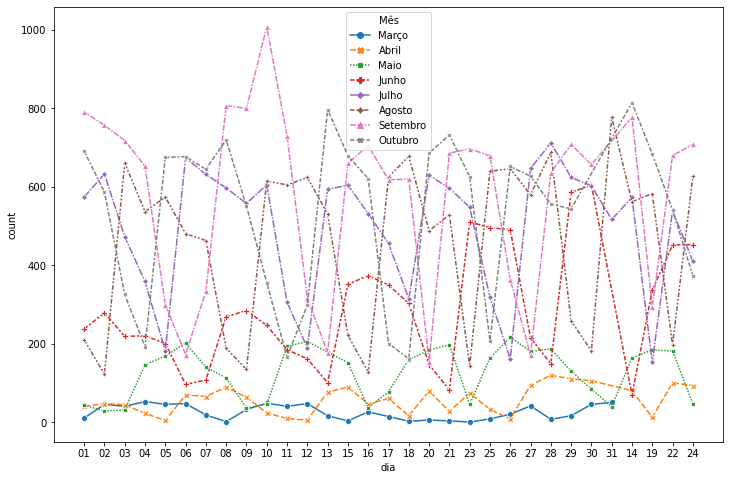

In [51]:
# https://seaborn.pydata.org/generated/seaborn.lineplot.html
plt.figure(figsize=(12,8))

sns.lineplot(data = grafico1, x = 'dia', y = 'count', hue = 'Mês', style = 'Mês', markers = True)
plt.show()

> Não é possível notar um padrão no número de chamadas com base no dia da semana

In [ ]:
grafico12 = q1.groupby(['Mês'], sort=False).agg({'id':'count'}).reset_index(drop = False)
grafico12 = grafico12.rename(columns= {'id':'count'})
grafico12

,Mês,count
0,Fevereiro,91
1,Março,708
2,Abril,1730
3,Maio,3978
4,Junho,8587
5,Julho,15318
6,Agosto,14305
7,Setembro,17381
8,Outubro,15391


In [52]:
# q1.data.dt.strftime('%d').unique()

31

> Podemos desconsiderar o mês de Fevereiro das Análises pois os registros começam ao final do mês. 

In [57]:
grafico12 = q1.groupby('Mês', sort=False).agg({'id':'count'}).reset_index(drop = False)
grafico12 = grafico12.rename(columns= {'id':'count'})
grafico12

,Mês,count
0,Fevereiro,91
1,Março,708
2,Abril,1730
3,Maio,3978
4,Junho,8587
5,Julho,15318
6,Agosto,14305
7,Setembro,17381
8,Outubro,15391


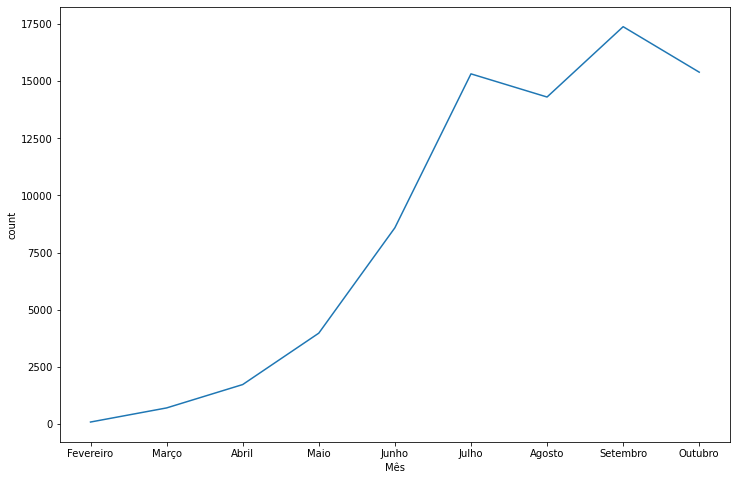

In [62]:
plt.figure(figsize=(12,8))

sns.lineplot(data = grafico12, x = 'Mês', y = 'count', markers = True)
plt.show()

<AxesSubplot:xlabel='Mês', ylabel='count'>

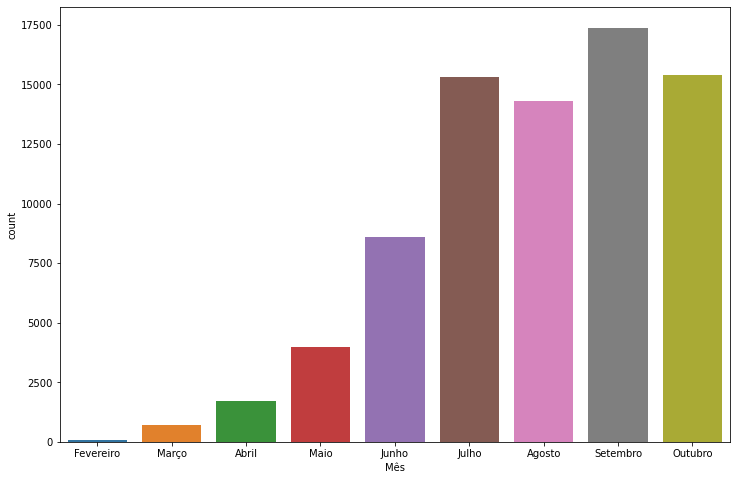

In [66]:
plt.figure(figsize=(12,8))

sns.barplot(data = grafico12, x = 'Mês', y = 'count')

In [85]:
grafico13 = grafico12.copy()
grafico13
grafico13['media'] = np.where((grafico13['Mês'] == 'Agosto') | (grafico13['Mês'] == 'Setembro') | (grafico13['Mês'] == 'Outubro'),'Pos Mudanca', 'Pre Mudanca')

In [86]:
grafico13

,Mês,count,media
0,Fevereiro,91,Pre Mudanca
1,Março,708,Pre Mudanca
2,Abril,1730,Pre Mudanca
3,Maio,3978,Pre Mudanca
4,Junho,8587,Pre Mudanca
5,Julho,15318,Pre Mudanca
6,Agosto,14305,Pos Mudanca
7,Setembro,17381,Pos Mudanca
8,Outubro,15391,Pos Mudanca


In [90]:
grafico13 = grafico13.groupby('media').agg({'count':'mean'}).reset_index(drop = False)
grafico13.columns = ['Mudanca', 'Media']
grafico13

,Mudanca,Media
0,Pos Mudanca,15692.333333
1,Pre Mudanca,5068.666667


<AxesSubplot:xlabel='Mudanca', ylabel='Media'>

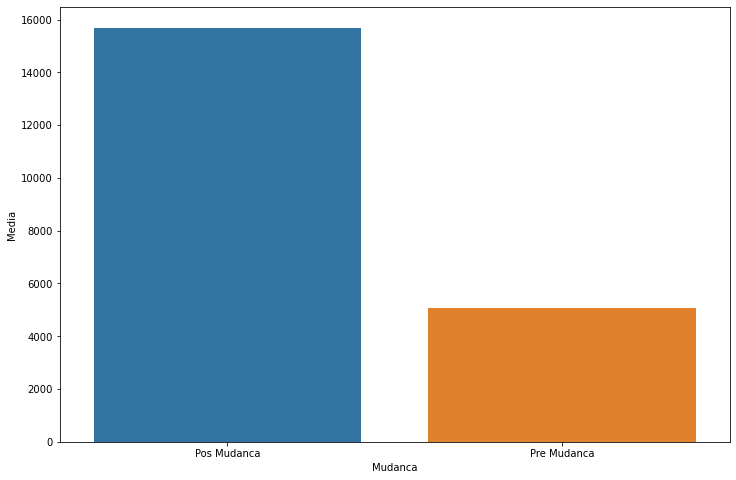

In [91]:
# Gráfico que mostra a média de chamadas antes e pós a mudança
plt.figure(figsize=(12,8))

sns.barplot(x = grafico13['Mudanca'] , y = grafico13['Media'])

> Duas respostas possíveis: Ou eu preciso fazer mais uma limpeza de dados e talvez haja valores duplicados para Setembro, Outubro, etc. ou a mudança nao surtiu efeito

# Questão 2

2.	Foi notado pelo nosso time que clientes recem credenciados possuem um comportamento específico em relação à quantidade de chamados realizados logo após seu credenciamento. Identifique e prepare alguma forma de visualizar essa diferença notada pelos agentes.

# Questão 3

3.	Para conseguir melhorar a qualidade do nosso atendimento ao cliente, foi proposto que a alguns chamados tenham prioridade de atendimento. Levando em consideração o motivo dos chamados, como você estabeleceria essa prioridade da fila de espera? Sugestão: Proponha uma clusterização da base de clientes que julgue atender da melhor forma a necessidade apresentada.

# Questão 4

4.	Escreva duas queries em SQL que retornem: 

i) o volume de chamados por semana dos últimos três meses para cada cluster de clientes proposto na questão 3.

ii) uma série histórica dia a dia, que para cada dia retorne o número de chamados referentes aos últimos 30 dias (por exemplo, para o dia 30/01, a query deve retornar a quantidade de chamados totais entre os dias 01/01 e 30/01)


# Questão 5

5.	Questão de estudo livre: Como é esperado de um analista de dados, traga insights relevantes sobre pontos de atenção e possíveis melhorias que você identificou ao analisar ambas as bases de dados. Além disso faça pelo menos duas perguntas relacionadas aos dados que julgue relevantes para análise, você também pode sugerir outros dados para enriquecer os aqui disponibilizados.